In [77]:
import pandas as pd
import numpy as np
from tslearn.clustering import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set()

In [55]:
import warnings
warnings.filterwarnings("ignore")

In [57]:
data_loader = CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")
print(X_train.shape)

(100, 275, 1)


In [58]:
seed = 0
np.random.seed(seed)
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

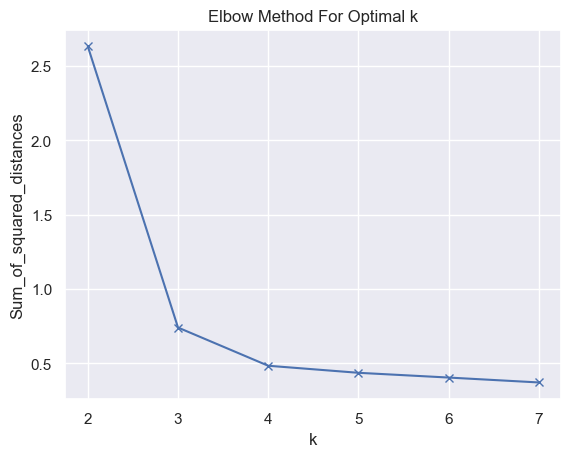

In [63]:
def plot_elbow_method(K, X_train):
    Sum_of_squared_distances = []
    for k in K:
        km = TimeSeriesKMeans(n_clusters=k,
                              n_init=2,
                              metric="dtw",
                              verbose=False,
                              max_iter_barycenter=10,
                              random_state=0)
        km.fit(X_train)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

K = range(2, 8)
plot_elbow_method(K, X_train)

In [61]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_kmeans_silhouette(X, range_n_clusters, variance_retained=0.95, random_state=0):
    """
    Perform KMeans clustering on PCA-transformed data and visualize silhouette scores and clusters.
    
    Parameters:
    - X: 2D numpy array, shape (n_samples, n_features), the input data
    - range_n_clusters: list of int, numbers of clusters to evaluate
    - variance_retained: float, proportion of variance to retain in PCA (default: 0.95)
    - random_state: int, seed for KMeans reproducibility (default: 0)
    """
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=variance_retained)
    X_pca = pca.fit_transform(X)

    # Iterate over the range of cluster numbers
    for n_clusters in range_n_clusters:
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # Set limits for the silhouette plot
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

        # Initialize and fit KMeans
        clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
        cluster_labels = clusterer.fit_predict(X_pca)

        # Compute the average silhouette score
        silhouette_avg = silhouette_score(X_pca, cluster_labels)
        print(f"For n_clusters = {n_clusters}, The average silhouette_score is : {silhouette_avg:.2f}")

        # Compute silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

        # Plot silhouette scores
        y_lower = 10
        for i in range(n_clusters):
            # Extract and sort silhouette values for cluster i
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            # Fill the silhouette plot area
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label each cluster in the silhouette plot
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        # Customize the silhouette plot
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Plot the clusters using the first two PCA components
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

        # Plot cluster centers
        centers = clusterer.cluster_centers_
        ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")
        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")

        # Customize the cluster plot
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        # Add a super title
        plt.suptitle(
            f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}",
            fontsize=14,
            fontweight="bold",
        )

    # Display all plots
    plt.show()

For n_clusters = 2, The average silhouette_score is : 0.62
For n_clusters = 3, The average silhouette_score is : 0.61
For n_clusters = 4, The average silhouette_score is : 0.53
For n_clusters = 5, The average silhouette_score is : 0.52


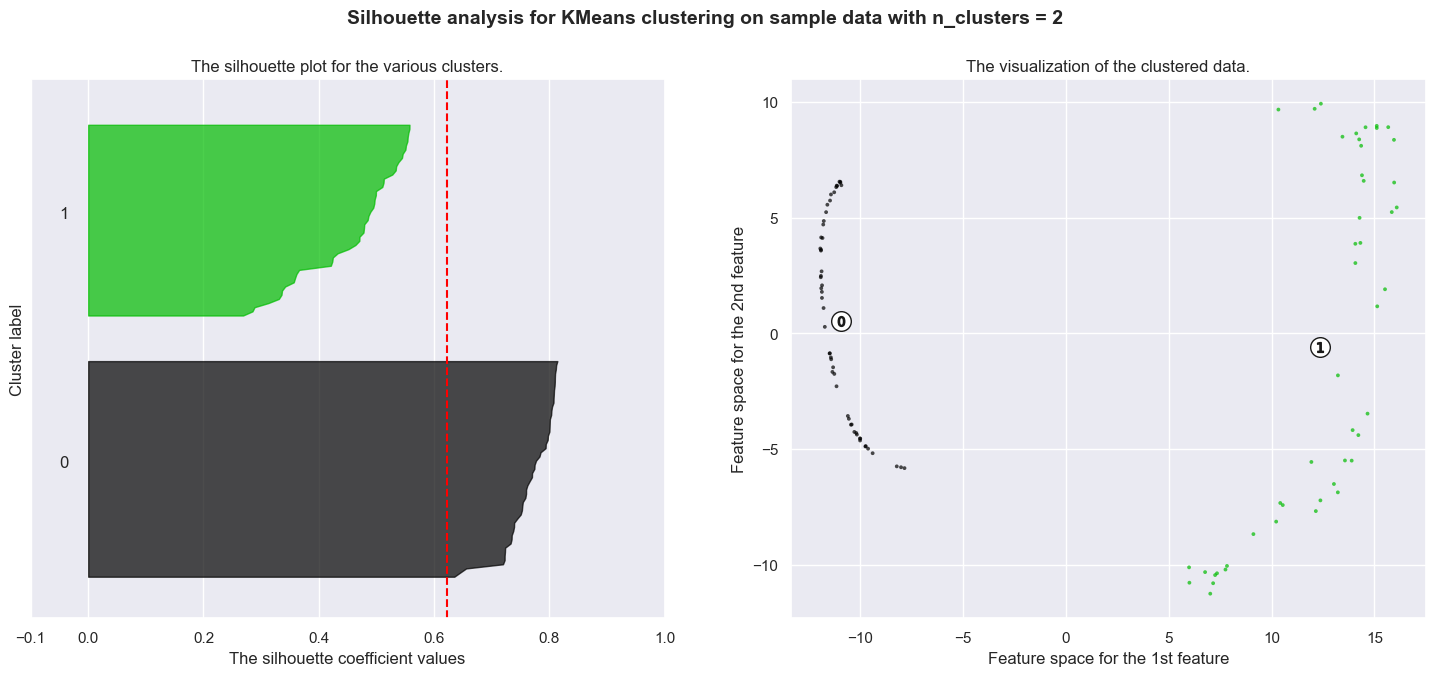

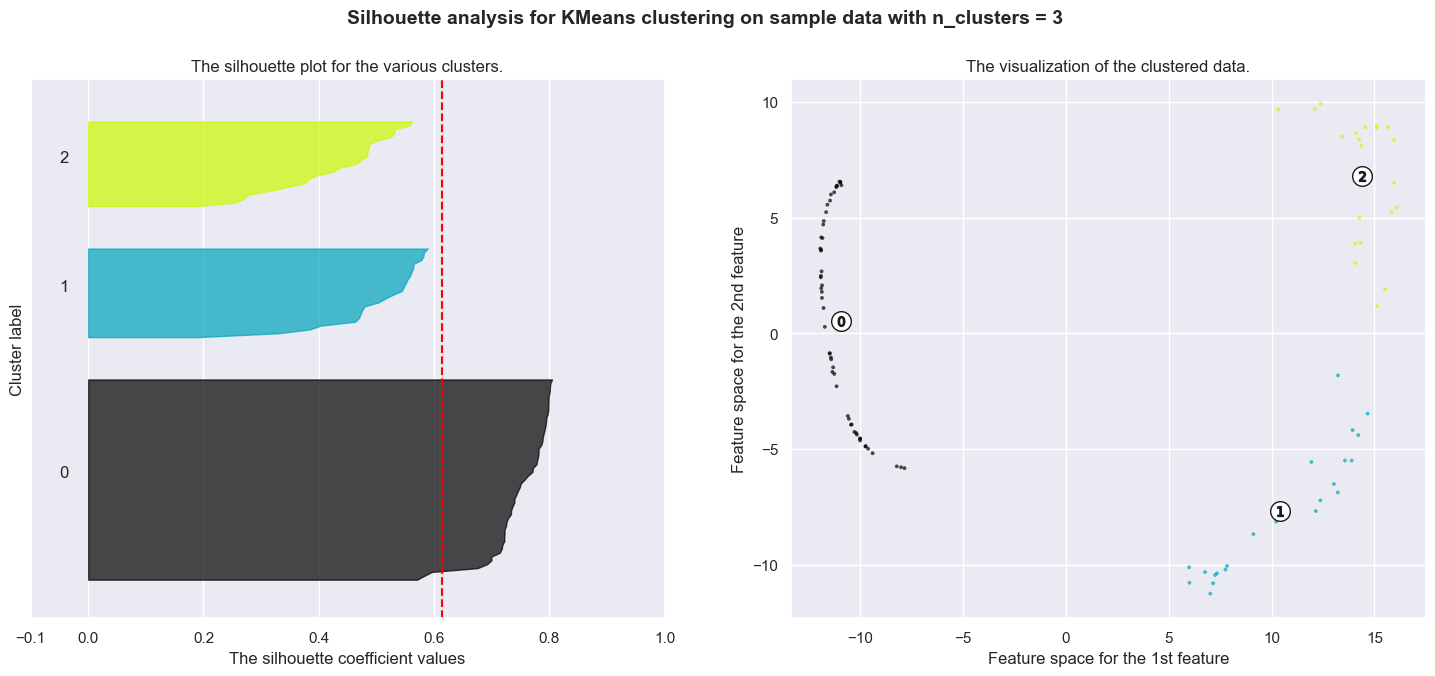

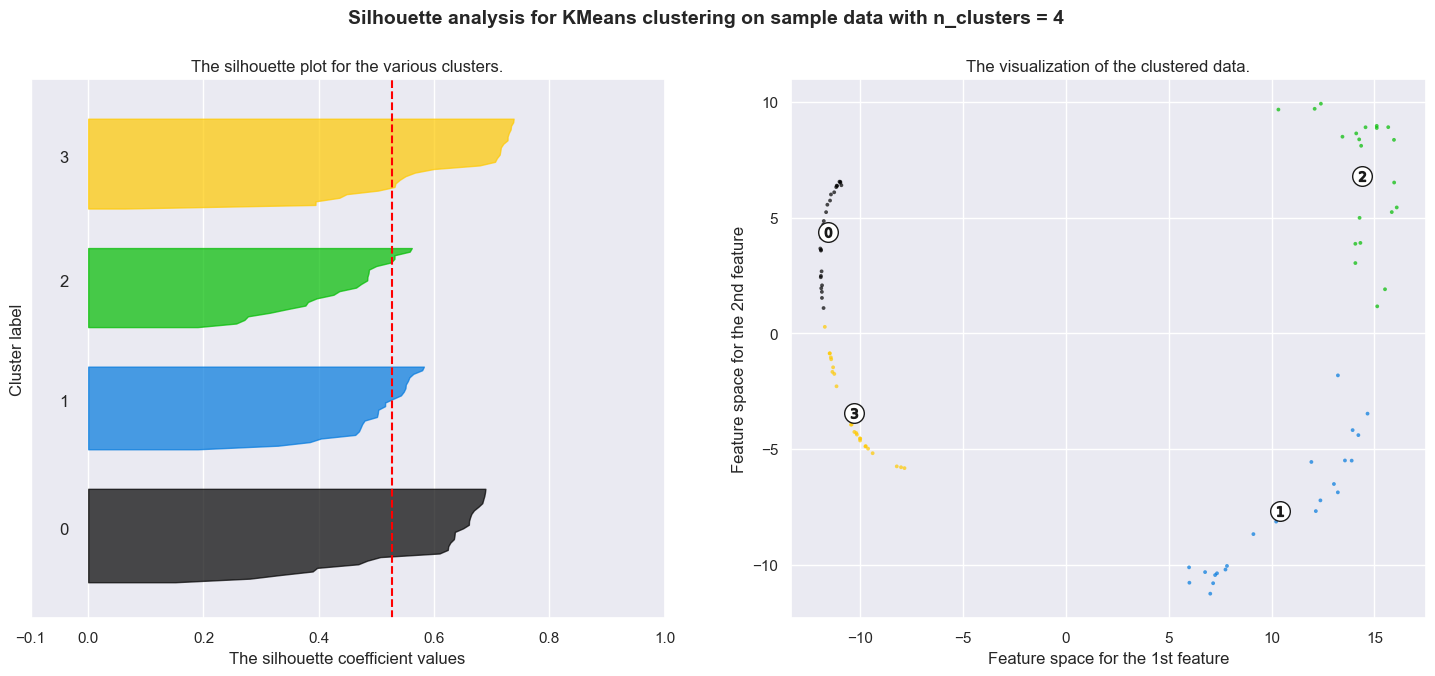

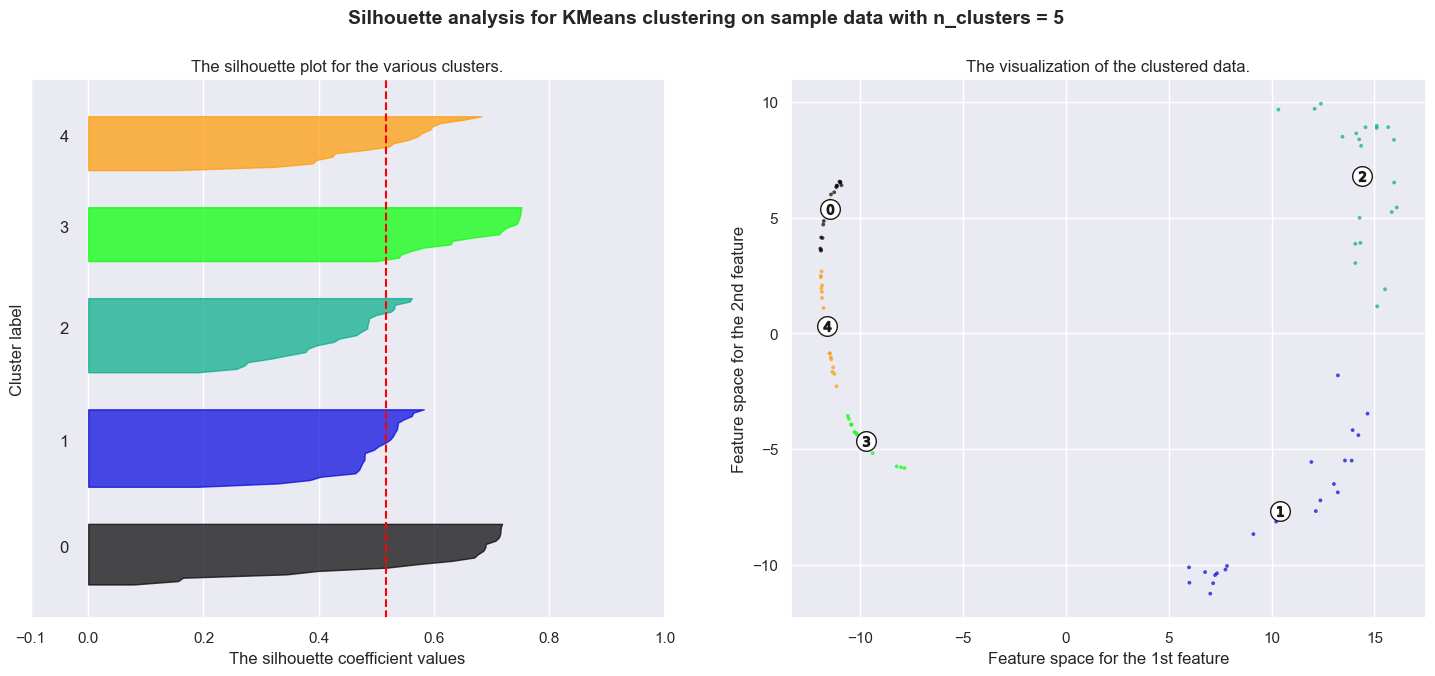

In [62]:
range_n_clusters = [2, 3, 4, 5]
X = list(X_train.reshape(X_train.shape[0], X_train.shape[1]))
plot_kmeans_silhouette(X, range_n_clusters)

Although n_clusters = 2 provides us with the highest silhouette score, it is important for every cluster to outperform the average score, which is achieved for n_clusters = 4. However, we can see that for n=3 our clusters look much better visually compared to n=4, Therefore we will continue with n=3.

In [82]:
from sklearn.metrics import silhouette_score as sk_silhouette_score
import math

def plot_timeseries_kmeans(X_train, metric, n_clusters, seed=0):
    """
    Perform TimeSeriesKMeans clustering and plot the results.

    Parameters:
    - X_train: numpy array, shape (n_samples, n_timesteps) or (n_samples, n_timesteps, n_features)
      The time series data to cluster.
    - metric: str, either "dtw" or "euclidean"
      The distance metric for clustering and silhouette score.
    - n_clusters: int
      The number of clusters to form.
    - seed: int, optional (default=0)
      Random seed for reproducibility.
    """
    # Initialize the clustering model
    km = TimeSeriesKMeans(
        n_clusters=n_clusters,
        n_init=2,
        metric=metric,
        verbose=False,
        max_iter_barycenter=10,
        random_state=seed
    )

    if metric == "euclidean":
        # For Euclidean, reshape X_train to 2D if it's 3D
        if X_train.ndim == 3:
            n_samples, n_timesteps, n_features = X_train.shape
            X_train_reshaped = X_train.reshape(n_samples, n_timesteps * n_features)
        else:
            X_train_reshaped = X_train
        y_pred = km.fit_predict(X_train_reshaped)
        # Use sklearn's silhouette_score for 2D data
        sil_score = sk_silhouette_score(X_train_reshaped, y_pred, metric="euclidean")
    elif metric == "dtw":
        # For DTW, use X_train as is (2D or 3D)
        y_pred = km.fit_predict(X_train)
        # Use tslearn's silhouette_score for time series
        sil_score = silhouette_score(X_train, y_pred, metric="dtw")
    else:
        raise ValueError("Unsupported metric. Use 'dtw' or 'euclidean'.")

    print(f"{metric.upper()} silhouette: {sil_score:.2f}")

    # Determine the length of the time series
    sz = X_train.shape[1]

    # Set up the subplot grid
    ncols = min(3, n_clusters)
    nrows = math.ceil(n_clusters / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
    axes = axes.flatten()

    # Plot each cluster
    for yi in range(n_clusters):
        ax = axes[yi]
        # Plot time series in the cluster
        if metric == "euclidean":
            for xx in X_train_reshaped[y_pred == yi]:
                ax.plot(xx, "k-", alpha=0.2)  # Already 1D after reshape
            # Reshape cluster center back for plotting
            center = km.cluster_centers_[yi].reshape(sz, -1) if X_train.ndim == 3 else km.cluster_centers_[yi]
        else:
            for xx in X_train[y_pred == yi]:
                ax.plot(xx.ravel(), "k-", alpha=0.2)
            center = km.cluster_centers_[yi]
        ax.plot(center.ravel(), "r-")
        ax.set_xlim(0, sz)
        ax.set_ylim(-4, 4)
        ax.text(0.55, 0.85, f"Cluster {yi + 1}", transform=ax.transAxes)

    fig.suptitle(f"TimeSeriesKMeans clustering with metric={metric}", fontsize=16)
    for yi in range(n_clusters, len(axes)):
        axes[yi].set_visible(False)
    plt.show()

EUCLIDEAN silhouette: 0.57


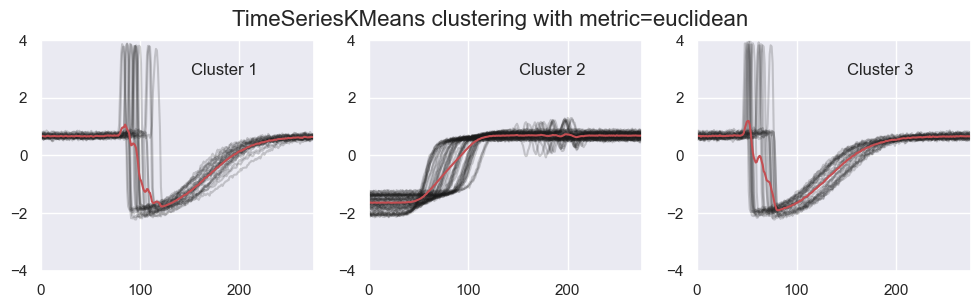

In [86]:
n_clusters = 3
metric="euclidean"
plot_timeseries_kmeans(X_train, metric, n_clusters, seed=0)

DTW silhouette: 0.87


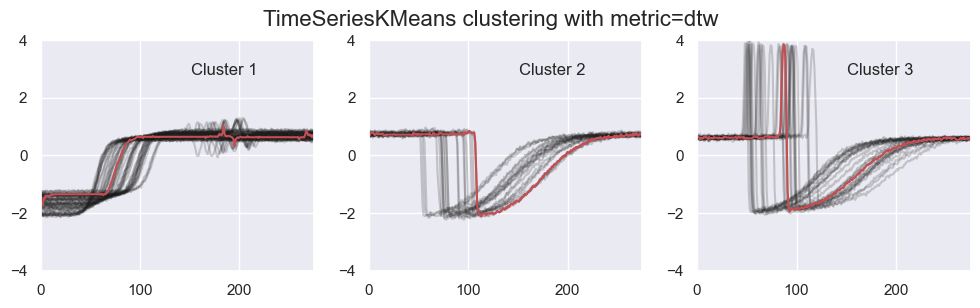

In [87]:
metric="dtw"
plot_timeseries_kmeans(X_train, metric, n_clusters, seed=0)

EUCLIDEAN silhouette: 0.53


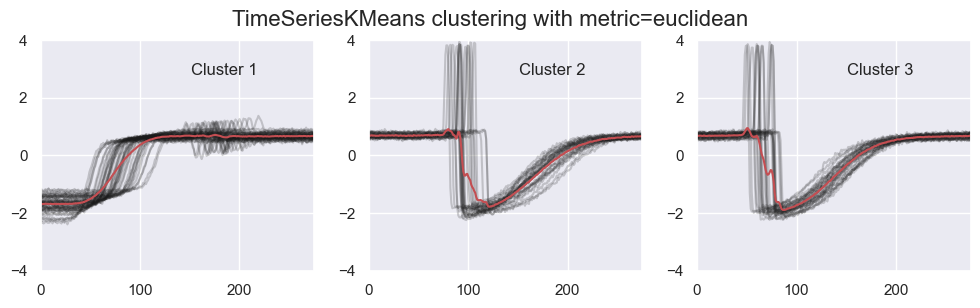

In [89]:
metric="euclidean"
plot_timeseries_kmeans(X_test, metric, n_clusters, seed=0)

DTW silhouette: 0.88


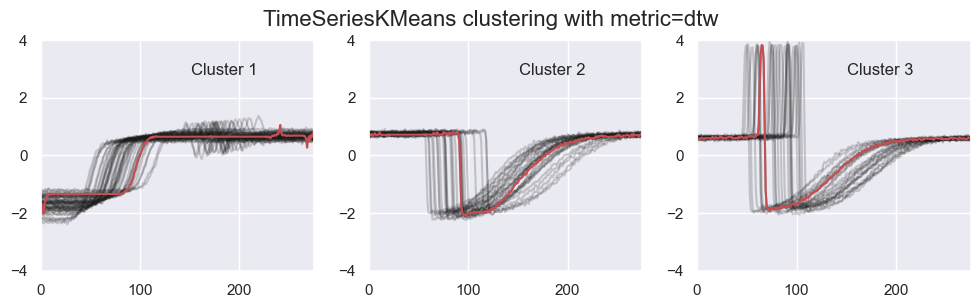

In [88]:
metric="dtw"
plot_timeseries_kmeans(X_test, metric, n_clusters, seed=0)